In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
df = pd.read_csv("/content/drive/MyDrive/financial_transactions.csv")
print(df.head())

   transaction_id        date  customer_id   amount    type  \
0               1  26-10-2020          NaN      NaN  credit   
1               2  08-01-2020        466.0  1255.95  credit   
2               3  02-09-2019        110.0  7969.68   debit   
3               4  02-12-2020        142.0  2927.41  credit   
4               5  02-12-2020        944.0  4661.88   debit   

                                         description  
0                 Expect series shake art again our.  
1               Each left similar likely coach take.  
2  Direction wife job pull determine leader move ...  
3                    Agree reveal buy black already.  
4       Child relationship show college whom speech.  


In [16]:
df = df.dropna(subset=['customer_id'])
df['customer_id'] = df['customer_id'].astype(int)
df['amount'] = df['amount'].fillna(0)
print(df.head())

   transaction_id        date  customer_id   amount    type  \
1               2  08-01-2020          466  1255.95  credit   
2               3  02-09-2019          110  7969.68   debit   
3               4  02-12-2020          142  2927.41  credit   
4               5  02-12-2020          944  4661.88   debit   
5               6  25-04-2021          900  3649.68  credit   

                                         description  
1               Each left similar likely coach take.  
2  Direction wife job pull determine leader move ...  
3                    Agree reveal buy black already.  
4       Child relationship show college whom speech.  
5                                Century front item.  


In [17]:
customer_data = df.groupby('customer_id').agg(
    total_amount=('amount', 'sum'),
    avg_transaction_amount=('amount', 'mean'),
    num_transactions=('amount', 'count')
).reset_index()
print(customer_data.head())

   customer_id  total_amount  avg_transaction_amount  num_transactions
0            1     481760.83             4966.606495                97
1            2     493403.13             4699.077429               105
2            3     547765.88             5071.906296               108
3            4     505827.29             5558.541648                91
4            5     527998.55             4934.565888               107


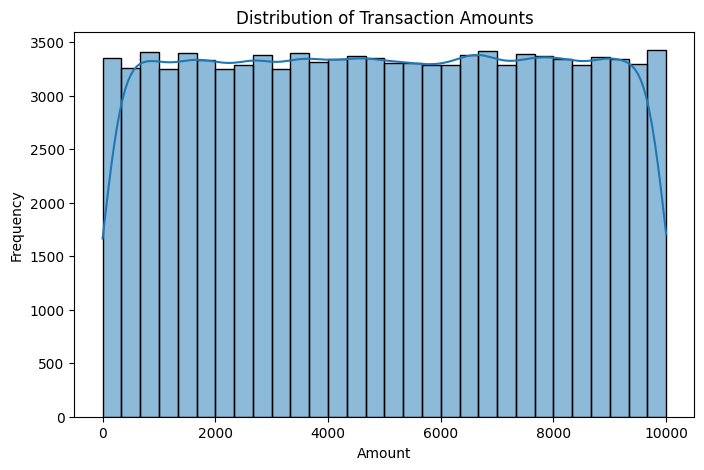

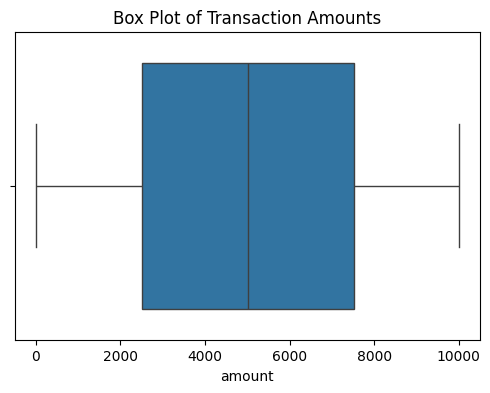

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(df['amount'], bins=30, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['amount'])
plt.title('Box Plot of Transaction Amounts')
plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data[["total_amount", "avg_transaction_amount", "num_transactions"]])


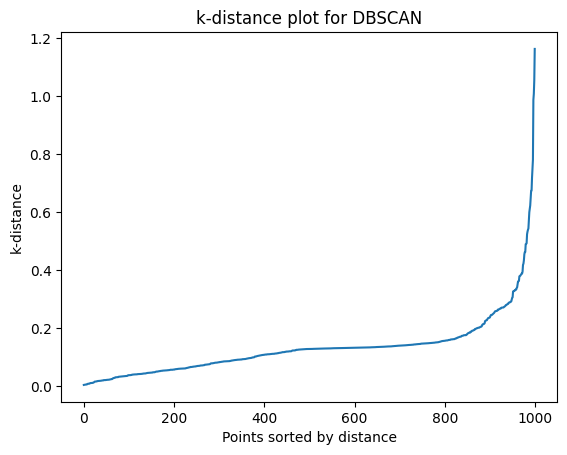

In [20]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# k = min_samples
k = 3
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# Sort distances of the k-th neighbor
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.ylabel("k-distance")
plt.xlabel("Points sorted by distance")
plt.title("k-distance plot for DBSCAN")
plt.show()


In [21]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=3)  # Tune these parameters
customer_data["cluster"] = dbscan.fit_predict(X_scaled)

# Display clustering results
print(customer_data["cluster"].value_counts())


cluster
 0     799
-1     100
 6      12
 4      11
 1      11
 11      8
 5       6
 7       5
 3       5
 10      5
 8       4
 9       4
 14      4
 12      4
 15      4
 2       3
 16      3
 13      3
 18      3
 19      3
 17      3
Name: count, dtype: int64


In [22]:
unique_clusters = len(set(customer_data["cluster"])) - (1 if -1 in customer_data["cluster"].values else 0)
if unique_clusters != 3:
    print(f"DBSCAN found {unique_clusters} clusters. Switching to KMeans for exactly 3 clusters.")
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    customer_data["cluster"] = kmeans.fit_predict(X_scaled)
print(customer_data)

DBSCAN found 20 clusters. Switching to KMeans for exactly 3 clusters.
     customer_id  total_amount  avg_transaction_amount  num_transactions  \
0              1     481760.83             4966.606495                97   
1              2     493403.13             4699.077429               105   
2              3     547765.88             5071.906296               108   
3              4     505827.29             5558.541648                91   
4              5     527998.55             4934.565888               107   
..           ...           ...                     ...               ...   
995          996     445988.18             4744.555106                94   
996          997     495530.38             5005.357374                99   
997          998     460563.98             5355.395116                86   
998          999     513823.67             5466.209255                94   
999         1000     529241.20             5040.392381               105   

     cluster  
0 

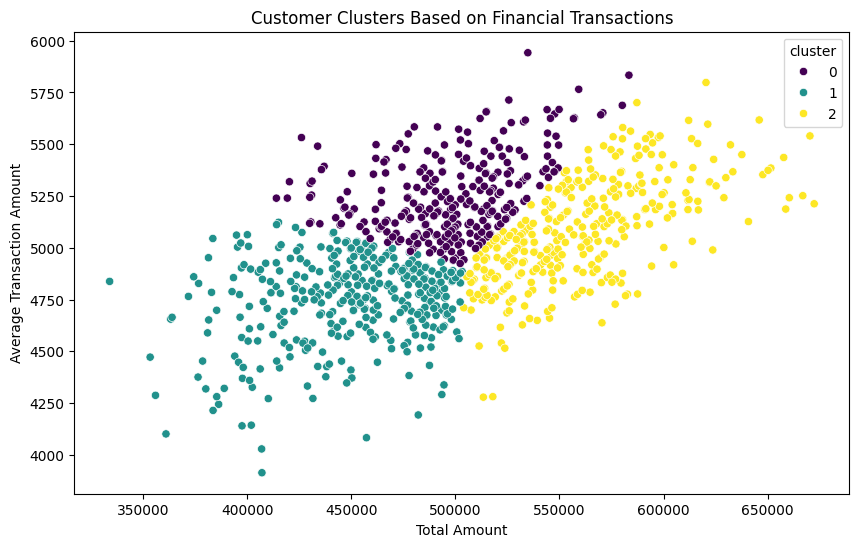

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_data["total_amount"], y=customer_data["avg_transaction_amount"], hue=customer_data["cluster"], palette="viridis")
plt.xlabel("Total Amount")
plt.ylabel("Average Transaction Amount")
plt.title("Customer Clusters Based on Financial Transactions")
plt.show()

In [24]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Ensure DBSCAN has at least 2 clusters for evaluation
if len(set(customer_data["cluster"])) > 1:
    silhouette_avg = silhouette_score(X_scaled, customer_data["cluster"])
    calinski_score = calinski_harabasz_score(X_scaled, customer_data["cluster"])
    davies_bouldin = davies_bouldin_score(X_scaled, customer_data["cluster"])
    accuracy_score = (silhouette_avg + 1) * 50
    print("\n🔹 DBSCAN Clustering Evaluation")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Calinski-Harabasz Score: {calinski_score:.2f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f} (lower is better)")
    print(f"Estimated Clustering Accuracy: {accuracy_score:.2f}%")
else:
    print("DBSCAN found only one cluster or all points are noise. Adjust parameters.")



🔹 DBSCAN Clustering Evaluation
Silhouette Score: 0.3253
Calinski-Harabasz Score: 664.10
Davies-Bouldin Score: 1.0156 (lower is better)
Estimated Clustering Accuracy: 66.27%
